# Happiness/GDP/Alcohol vs. Population Analysis

## Library Imports

In [1]:
#import dependencies 
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from scipy.stats import linregress

## Importing Happiness, GDP, and Alcohol Consumption Information

In [2]:
data_df=pd.read_csv("Data/HappinessAlcoholConsumption.csv")
data_df.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97


## Dataframe Information
We use this section to look at the information this dataframe holds as well as clean it before use.

In [3]:
data_df = data_df.dropna()

data_df.dtypes

Country              object
Region               object
Hemisphere           object
HappinessScore      float64
HDI                   int64
GDP_PerCapita       float64
Beer_PerCapita        int64
Spirit_PerCapita      int64
Wine_PerCapita        int64
dtype: object

While doing an initial analysis, we noticed that the GDP_PerCapita didn't match what we were seeing elsewhere. There were many countries that had a smaller GDP Per Capita, by a factor of 1000. We realized from our data source, that the data source may have come from somewhere outside of the US where periods are used instead of commas as the thousands separator. Looking at the initial data source, we saw that the other rows did not have a decimal in its value, which further led us to believe that we had an issue with the thousands separator. We found those rows below, multiplied the GDP_PerCapita by 1000 for those having the period and not the others.

In [4]:
+data_df.loc[
    data_df["GDP_PerCapita"] % 1 > 0, :
].head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97


In [5]:
for index, row in data_df.iterrows():
    if row["GDP_PerCapita"] % 1 > 0:
        data_df.loc[index, "GDP_PerCapita"] = int(1000 * row["GDP_PerCapita"])
        
data_df.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53579.0,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79866.0,185,100,280
2,Iceland,Western Europe,north,7.501,933,60530.0,233,61,78
3,Norway,Western Europe,north,7.498,951,70890.0,169,71,129
4,Finland,Western Europe,north,7.413,918,43433.0,263,133,97


We can see that there are no other rows with incorrect GDP_PerCapita data.

In [6]:
data_df.loc[
    data_df["GDP_PerCapita"] % 1 > 0, :
].head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita


In [7]:
#shape of dataframe
data_df.shape

(122, 9)

In [8]:
#unique hemispheres and their counts
data_df.groupby("Hemisphere").count()["Country"]

Hemisphere
both      5
north    92
noth      4
south    21
Name: Country, dtype: int64

As you can see above, there is a misprint in the data, that "noth" instead of "north." The cells below update the dataframe to fix that issue.

In [9]:
data_df.loc[data_df["Hemisphere"] == 'noth',:]

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
46,Japan,Eastern Asia,noth,5.921,907,38972.0,77,202,16
51,South Korea,Eastern Asia,noth,5.835,900,27105.0,140,16,9
70,China,Eastern Asia,noth,5.245,748,8117.0,79,192,8
84,Mongolia,Eastern Asia,noth,4.907,743,3694.0,77,189,8


In [10]:
for index, row in data_df.iterrows():
    if row["Hemisphere"] == "noth":
        data_df.loc[index, "Hemisphere"] = "north"

data_df.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53579.0,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79866.0,185,100,280
2,Iceland,Western Europe,north,7.501,933,60530.0,233,61,78
3,Norway,Western Europe,north,7.498,951,70890.0,169,71,129
4,Finland,Western Europe,north,7.413,918,43433.0,263,133,97


As you can see below, there are no more rows with that issue.

In [11]:
data_df.loc[data_df["Hemisphere"] == 'noth',:]

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita


In [12]:
# The updated Hemisphere values are updating.
data_df.groupby("Hemisphere").count()["Country"]

Hemisphere
both      5
north    96
south    21
Name: Country, dtype: int64

In [13]:
#unique regions
data_df["Region"].unique()

array(['Western Europe', 'North America', 'Australia and New Zealand',
       'Middle East and Northern Africa', 'Latin America and Caribbean',
       'Southeastern Asia', 'Central and Eastern Europe', 'Eastern Asia',
       'Sub-Saharan Africa'], dtype=object)

In [14]:
#unique countries
data_df["Country"].unique()

array(['Denmark', 'Switzerland', 'Iceland', 'Norway', 'Finland', 'Canada',
       'Netherlands', 'New Zealand', 'Australia', 'Sweden', 'Israel',
       'Austria', 'United States', 'Costa Rica', 'Germany', 'Brazil',
       'Belgium', 'Ireland', 'Luxembourg', 'Mexico', 'Singapore',
       'United Kingdom', 'Chile', 'Panama', 'Argentina', 'Czech Republic',
       'United Arab Emirates', 'Uruguay', 'Malta', 'Colombia', 'France',
       'Thailand', 'Qatar', 'Spain', 'Guatemala', 'Suriname', 'Bahrain',
       'Trinidad and Tobago', 'Venezuela', 'Slovakia', 'El Salvador',
       'Nicaragua', 'Uzbekistan', 'Italy', 'Ecuador', 'Belize', 'Japan',
       'Kazakhstan', 'Moldova', 'Russian Federation', 'Poland',
       'South Korea', 'Bolivia', 'Lithuania', 'Belarus', 'Slovenia',
       'Peru', 'Turkmenistan', 'Mauritius', 'Latvia', 'Cyprus',
       'Paraguay', 'Romania', 'Estonia', 'Jamaica', 'Croatia', 'Turkey',
       'Jordan', 'Azerbaijan', 'Philippines', 'China', 'Kyrgyzstan',
       'Serbia',

## Importing Population Data

We want to create the GDP Per Capita per regions, but in order to do so, we need to have the population of each country. We found a dataset that has the population of each country, but while our data set above is from 2016, the closest we could find was 2018 for population. The dataset has other features to it, but we're restricting it to the population for that year.

In [15]:
pop_data = pd.read_csv("Data/Population Data/Global Population Trends(2016-2022).csv")
pop_data_2018 = pop_data.loc[pop_data["Year"] == 2018, ["Country", "Total Population"]]
print(pop_data_2018.dtypes)
pop_data_2018.head()

Country             object
Total Population    object
dtype: object


,Country,Total Population
1,Afghanistan,"36,686,784"
6,Albania,"2,866,376"
11,Algeria,"41,927,007"
15,American Samoa,"48,424"
19,Andorra,"75,013"


Above, it is clear that the population is not a number as it is an "object" type. This means the values must be turned into numerical values instead. To do this, we remove the commas from the number, then update it to an integer type.

In [16]:
pop_data_2018["Total Population"]=pop_data_2018["Total Population"].str.replace(",","")
pop_data_2018["Total Population"] = pop_data_2018["Total Population"].astype("int64")
pop_data_2018.dtypes

Country             object
Total Population     int64
dtype: object

Merging the two dataframes together... I opted to use a right join to see all of the countries in the gdp/happiness/alcohol file.

In [17]:
merged_data = pop_data_2018.merge(data_df,
                                  how = "right",
                                  left_on = "Country",
                                  right_on = "Country",
                                  suffixes = ("_pop", "_data"),
                                  indicator = True
                                 )
merged_data

,Country,Total Population,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita,_merge
0,Denmark,5793636.0,Western Europe,north,7.526,928,53579.0,224,81,278,both
1,Switzerland,8514329.0,Western Europe,north,7.509,943,79866.0,185,100,280,both
2,Iceland,352721.0,Western Europe,north,7.501,933,60530.0,233,61,78,both
3,Norway,5311916.0,Western Europe,north,7.498,951,70890.0,169,71,129,both
4,Finland,5515525.0,Western Europe,north,7.413,918,43433.0,263,133,97,both
...,...,...,...,...,...,...,...,...,...,...,...
117,Tanzania,58090443.0,Sub-Saharan Africa,south,3.666,533,878.0,36,6,1,both
118,Liberia,4889391.0,Sub-Saharan Africa,north,3.622,432,455.0,19,152,2,both
119,Benin,11940683.0,Sub-Saharan Africa,north,3.484,512,789.0,34,4,13,both
120,Togo,8046679.0,Sub-Saharan Africa,north,3.303,500,577.0,36,2,19,both


In the merged file, I wasn't able to show the "Country" column for both dataframes, which is what I wanted to find those countries in one file that didn't have a match in the other file. However, I found the "indicator" argument within pandas.merge() that allowed me to find those.

In the cells below, I plan to programmatically update each dataframe to match the country in the other file with a more appropriate name. I'll show those countries below.

In [18]:
# These are the countries that show in the Happiness / GDP / Alcohol data, but not in Population automatically.
# We'll look for them manually in the Population data.
missed_countries = merged_data.loc[merged_data["_merge"].isin(["right_only"]), "Country"].sort_values().unique()
missed_countries

array(['Bosnia and Herzegovina', "Cote d'Ivoire", 'Dem. Rep. Congo',
       'Kyrgyzstan', 'Macedonia', 'Rep. Congo', 'Russian Federation',
       'Slovakia', 'Syria', 'Trinidad and Tobago', 'United Arab Emirates'],
      dtype=object)

In [19]:
pop_data_2018.loc[:,"Country"].sort_values().unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Cayman Islands', 'Central African Republic', 'Chad',
       'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Costa Rica', 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic Of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'Finland',
       'France', 'French Polynesia', 'Gabon

From the two lists, it's easy to see that the following countries in the happiness dataset have the listed names from the happiness / gdp / alcohol data set, what the corresponding name in the population dataset is, and which table it'll be adjusted:

| 'Happiness / GDP / Alcohol' Name | Population Name | Where to Fix? |
| :------------------------------- | :-------------- | :------------ |
| Bosnia and Herzegovina | Bosnia | Left |
| Cote d'Ivoire | *Missing* | *N/A* |
| Dem. Rep. Congo | Democratic Republic of Congo | Left | 
| Kyrgyzstan | Kyrgyz Republic | Right |
| Macedonia | North Macedonia | Left |
| Rep. Congo | Republic of Congo | Left |
| Russian Federation | Russia | Left |
| Slovakia | Slovak Republic | Right | 
| Syria | Syrian Arab Republic | Right |
| Trinidad and Tobago | Trinidad And Tobago | Right |
| United Arab Emirates | UAE | Right |

In [20]:
left_list = [
    "Bosnia and Herzegovina", "Dem. Rep. Congo", "Kyrgyzstan", "Macedonia", "Rep. Congo",
    "Russian Federation", "Slovakia", "Syria", "Trinidad and Tobago", "United Arab Emirates"
]

right_list = [
    "Bosnia", "Democratic Republic of Congo", "Krygyz Republic", "North Macedonia",
    "Republic of Congo", "Russia", "Slovak Republic", "Syrian Arab Republic",
    "Trinidad And Tobago", "UAE"
]

fix_list = [
    "L", "L", "R", "L", "L", "L", "R", "R", "R", "R"
]

zipped = zip(left_list, right_list, fix_list)

for item in zipped:
    if item[2] == "L":
        merged_data.loc[merged_data["Country"] == item[0], "Country"] = item[1]
    else:
        merged_data.loc[merged_data["Country"] == item[1], "Country"] = item[0]

Dropping the "_merge" column

In [21]:
merged_data = merged_data.drop(columns = "_merge")
merged_data.head()

,Country,Total Population,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,5793636.0,Western Europe,north,7.526,928,53579.0,224,81,278
1,Switzerland,8514329.0,Western Europe,north,7.509,943,79866.0,185,100,280
2,Iceland,352721.0,Western Europe,north,7.501,933,60530.0,233,61,78
3,Norway,5311916.0,Western Europe,north,7.498,951,70890.0,169,71,129
4,Finland,5515525.0,Western Europe,north,7.413,918,43433.0,263,133,97


In [22]:
merged_data.dtypes

Country              object
Total Population    float64
Region               object
Hemisphere           object
HappinessScore      float64
HDI                   int64
GDP_PerCapita       float64
Beer_PerCapita        int64
Spirit_PerCapita      int64
Wine_PerCapita        int64
dtype: object

In [23]:
merged_data_complete = merged_data.copy()

merged_data_complete["GDP"] = merged_data_complete["Total Population"] * merged_data_complete["GDP_PerCapita"]
merged_data_complete["Beer"] = merged_data_complete["Total Population"] * merged_data_complete["Beer_PerCapita"]
merged_data_complete["Spirit"] = merged_data_complete["Total Population"] * merged_data_complete["Spirit_PerCapita"]
merged_data_complete["Wine"] = merged_data_complete["Total Population"] * merged_data_complete["Wine_PerCapita"]

merged_data_complete

,Country,Total Population,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita,GDP,Beer,Spirit,Wine
0,Denmark,5793636.0,Western Europe,north,7.526,928,53579.0,224,81,278,3.104172e+11,1.297774e+09,469284516.0,1.610631e+09
1,Switzerland,8514329.0,Western Europe,north,7.509,943,79866.0,185,100,280,6.800054e+11,1.575151e+09,851432900.0,2.384012e+09
2,Iceland,352721.0,Western Europe,north,7.501,933,60530.0,233,61,78,2.135020e+10,8.218399e+07,21515981.0,2.751224e+07
3,Norway,5311916.0,Western Europe,north,7.498,951,70890.0,169,71,129,3.765617e+11,8.977138e+08,377146036.0,6.852372e+08
4,Finland,5515525.0,Western Europe,north,7.413,918,43433.0,263,133,97,2.395558e+11,1.450583e+09,733564825.0,5.350059e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Tanzania,58090443.0,Sub-Saharan Africa,south,3.666,533,878.0,36,6,1,5.100341e+10,2.091256e+09,348542658.0,5.809044e+07
118,Liberia,4889391.0,Sub-Saharan Africa,north,3.622,432,455.0,19,152,2,2.224673e+09,9.289843e+07,743187432.0,9.778782e+06
119,Benin,11940683.0,Sub-Saharan Africa,north,3.484,512,789.0,34,4,13,9.421199e+09,4.059832e+08,47762732.0,1.552289e+08
120,Togo,8046679.0,Sub-Saharan Africa,north,3.303,500,577.0,36,2,19,4.642934e+09,2.896804e+08,16093358.0,1.528869e+08


In [24]:
region_data = merged_data_complete.groupby(["Region"])
per_capita_data = region_data[["Total Population", "GDP","Beer", "Spirit", "Wine"]].sum()

per_capita_data["GDP_per"] = per_capita_data["GDP"] / per_capita_data["Total Population"]
per_capita_data["Beer_per"] = per_capita_data["Beer"] / per_capita_data["Total Population"]
per_capita_data["Spirit_per"] = per_capita_data["Spirit"] / per_capita_data["Total Population"]
per_capita_data["Wine_per"] = per_capita_data["Wine"] / per_capita_data["Total Population"]

per_capita_data

,Total Population,GDP,Beer,Spirit,Wine,GDP_per,Beer_per,Spirit_per,Wine_per
Region,,,,,,,,,
Australia and New Zealand,2.986724e+07,1.443412e+12,7.511116e+09,2.184746e+09,6.150533e+09,48327.580318,251.483393,73.148556,205.929061
Central and Eastern Europe,2.381319e+08,1.735487e+12,4.660113e+10,4.370213e+10,1.612465e+10,7287.924368,195.694615,183.520691,67.713124
Eastern Asia,1.584320e+09,1.773818e+13,1.280480e+11,2.963691e+11,1.374063e+10,11196.085035,80.822068,187.063906,8.672890
Latin America and Caribbean,6.209358e+08,5.198035e+12,1.283175e+11,6.659007e+10,1.966317e+10,8371.290865,206.651736,107.241470,31.666985
Middle East and Northern Africa,2.639582e+08,2.035446e+12,6.692062e+09,3.857904e+09,1.586001e+09,7711.243234,25.352733,14.615586,6.008532
North America,3.639033e+08,2.039195e+13,9.027833e+10,5.616238e+10,3.116092e+10,56036.741731,248.083312,154.333248,85.629667
Southeastern Asia,2.962749e+08,1.283568e+12,2.653729e+10,3.984391e+10,3.526616e+08,4332.355802,89.569826,134.482915,1.190319
Sub-Saharan Africa,6.650066e+08,1.235485e+12,4.428153e+10,1.133115e+10,8.157508e+09,1857.852876,66.588098,17.039155,12.266807
Western Europe,4.251020e+08,1.638097e+13,9.260411e+10,4.708507e+10,9.338797e+10,38534.213655,217.839755,110.761818,219.683706


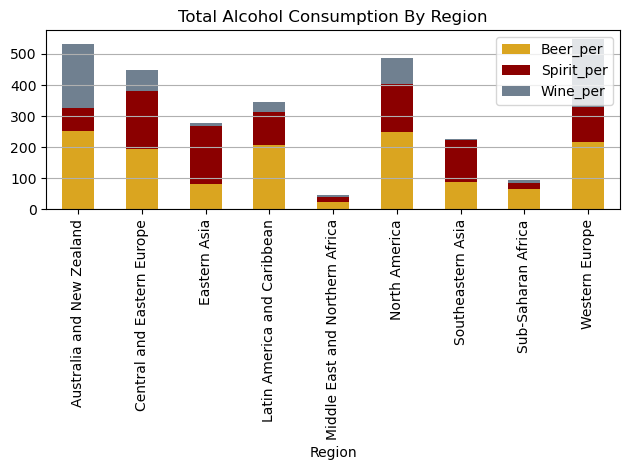

In [25]:
per_capita_data_copy = per_capita_data.copy()

per_capita_data_copy = per_capita_data_copy.reset_index()

per_capita_data_copy[["Region", "Beer_per", "Spirit_per", "Wine_per"]]\
    .plot.bar(x = "Region",
              stacked = True,
              title = "Total Alcohol Consumption By Region",
              color = ["goldenrod", "darkred", "slategray"],
              #figsize = (10, 8)
             )
plt.tight_layout()
plt.grid(axis = "y")

plt.savefig("output_data/Total Alcohol Consumption By Region.png")
plt.show()

## GDP Analysis
first by regional averages, then by country

In [26]:
#Analysing GDP
gdp_df=data_df[["Country","Region","GDP_PerCapita"]].copy()
gdp_df

,Country,Region,GDP_PerCapita
0,Denmark,Western Europe,53579.0
1,Switzerland,Western Europe,79866.0
2,Iceland,Western Europe,60530.0
3,Norway,Western Europe,70890.0
4,Finland,Western Europe,43433.0
...,...,...,...
117,Tanzania,Sub-Saharan Africa,878.0
118,Liberia,Sub-Saharan Africa,455.0
119,Benin,Sub-Saharan Africa,789.0
120,Togo,Sub-Saharan Africa,577.0


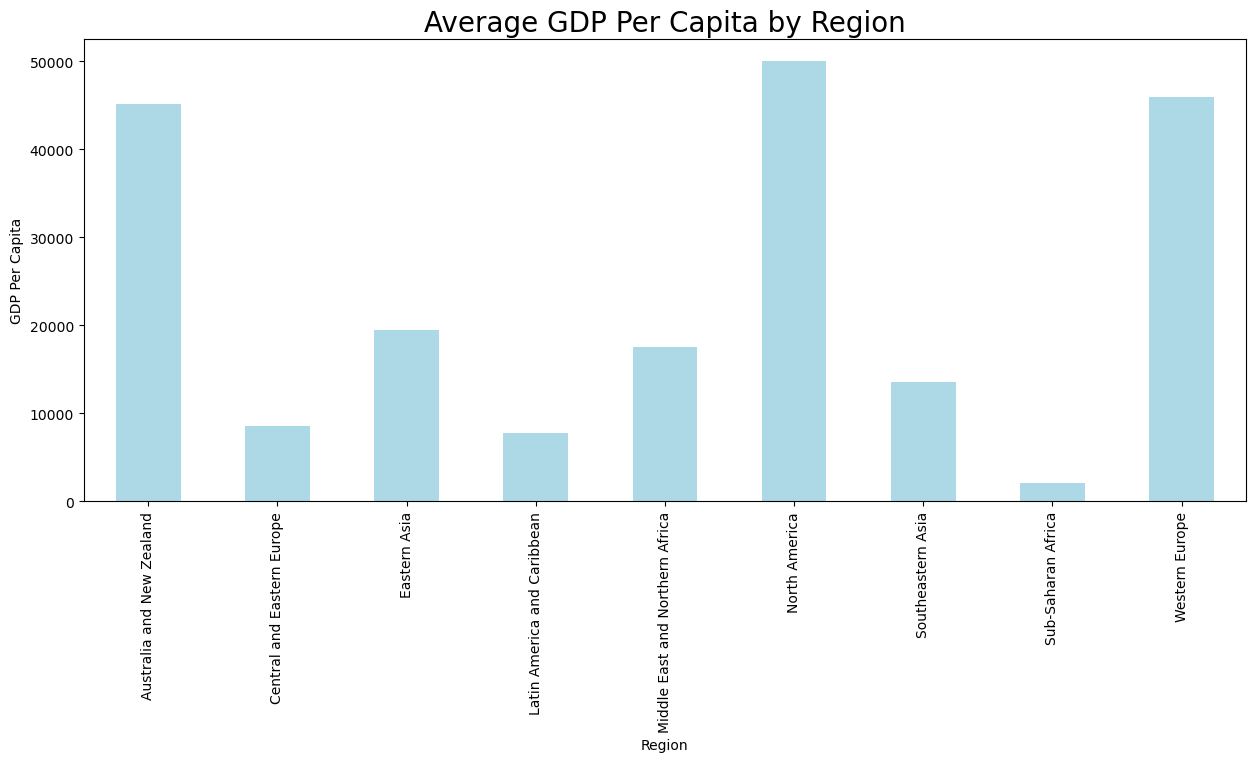

In [27]:
#Average GDP by Region
#***** need to adjust GDP per capita to just GDP (mult by pop of each country) before taking average
plt.figure(figsize=(15, 6))
gdp_df.groupby('Region')['GDP_PerCapita'].mean().plot(kind='bar', color='lightblue')
plt.title('Average GDP Per Capita by Region', fontsize=20)
plt.xlabel('Region')
plt.ylabel('GDP Per Capita')
plt.xticks(rotation=90)
plt.show()

Text(0, 0.5, 'GDP Per Capita')

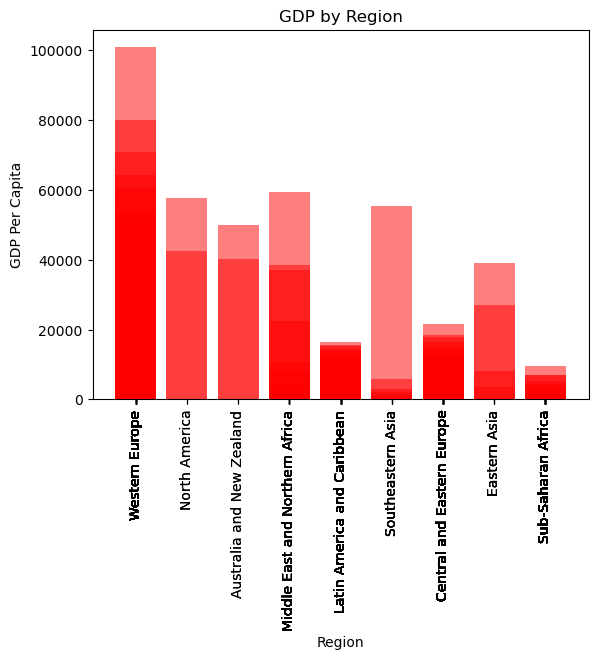

In [28]:
#chart for GDP by Region
gdp=gdp_df["GDP_PerCapita"]
region=gdp_df["Region"]

plt.bar(region,gdp,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=90)

plt.title("GDP by Region")
plt.xlabel("Region")
plt.ylabel("GDP Per Capita")


In [29]:
#top 20 GDP countries
gdp=gdp_df.sort_values(["GDP_PerCapita"],ascending=False)
gdp.head(25)

,Country,Region,GDP_PerCapita
18,Luxembourg,Western Europe,100739.0
1,Switzerland,Western Europe,79866.0
3,Norway,Western Europe,70890.0
17,Ireland,Western Europe,64099.0
2,Iceland,Western Europe,60530.0
32,Qatar,Middle East and Northern Africa,59324.0
12,United States,North America,57589.0
20,Singapore,Southeastern Asia,55243.0
0,Denmark,Western Europe,53579.0
9,Sweden,Western Europe,51845.0


<Figure size 1500x1000 with 0 Axes>

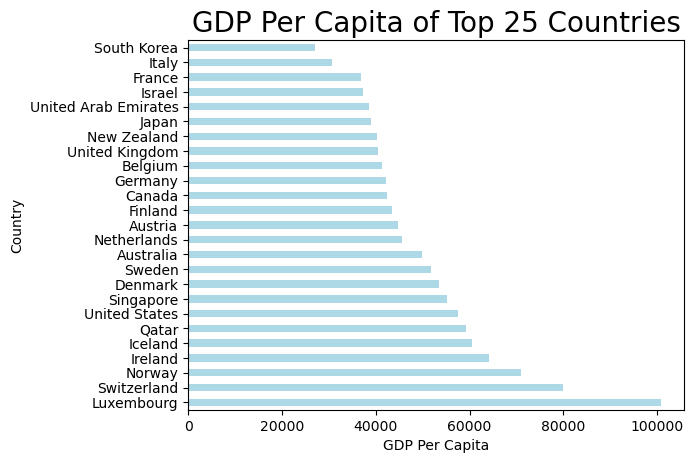

In [30]:
#chart top 25 countries by GDP
gdp=gdp_df["GDP_PerCapita"]
country=gdp_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = gdp_df.nlargest(25, 'GDP_PerCapita')
top_25_countries.plot(kind='barh', x='Country', y='GDP_PerCapita', color='lightblue', legend=False)
plt.title('GDP Per Capita of Top 25 Countries', fontsize=20)
plt.xlabel('GDP Per Capita')
plt.ylabel('Country')
plt.show()


In [31]:
#bottom 20 GDP countries
gdp=gdp_df.sort_values(["GDP_PerCapita"],ascending=True)
gdp.head(25)

,Country,Region,GDP_PerCapita
104,Malawi,Sub-Saharan Africa,300.0
113,Niger,Sub-Saharan Africa,368.0
116,Madagascar,Sub-Saharan Africa,402.0
118,Liberia,Sub-Saharan Africa,455.0
89,Sierra Leone,Sub-Saharan Africa,481.0
100,Rep. Congo,Sub-Saharan Africa,498.0
120,Togo,Sub-Saharan Africa,577.0
115,Burkina Faso,Sub-Saharan Africa,614.0
114,Chad,Sub-Saharan Africa,651.0
107,Haiti,Latin America and Caribbean,735.0


<Figure size 1500x1000 with 0 Axes>

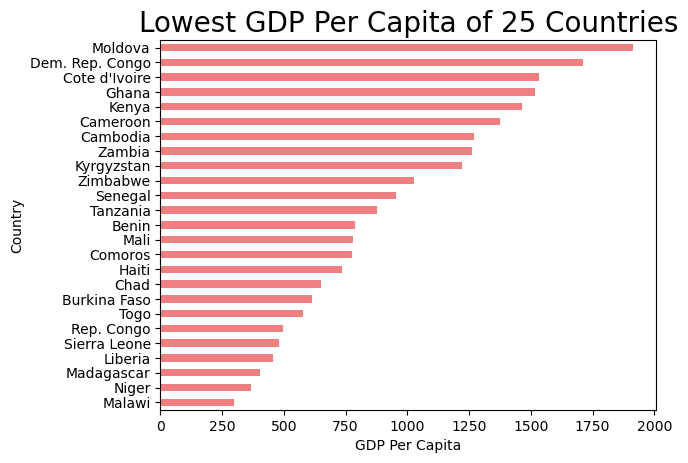

In [32]:
#Bottom 25 countries by GDP
plt.figure(figsize=(15, 10))
smallest_25_countries = gdp_df.nsmallest(25, 'GDP_PerCapita')
smallest_25_countries.plot(kind='barh', x='Country', y='GDP_PerCapita', color='lightcoral', legend=False)
plt.title('Lowest GDP Per Capita of 25 Countries', fontsize=20)
plt.xlabel('GDP Per Capita')
plt.ylabel('Country')
plt.show()

## Human Deveolpment Index (HDI)
first by regional averages, then by country

In [33]:
#Analysing for HDI by Region
hdi_df=data_df[["Country","Region","HDI"]].copy()
hdi_df

,Country,Region,HDI
0,Denmark,Western Europe,928
1,Switzerland,Western Europe,943
2,Iceland,Western Europe,933
3,Norway,Western Europe,951
4,Finland,Western Europe,918
...,...,...,...
117,Tanzania,Sub-Saharan Africa,533
118,Liberia,Sub-Saharan Africa,432
119,Benin,Sub-Saharan Africa,512
120,Togo,Sub-Saharan Africa,500


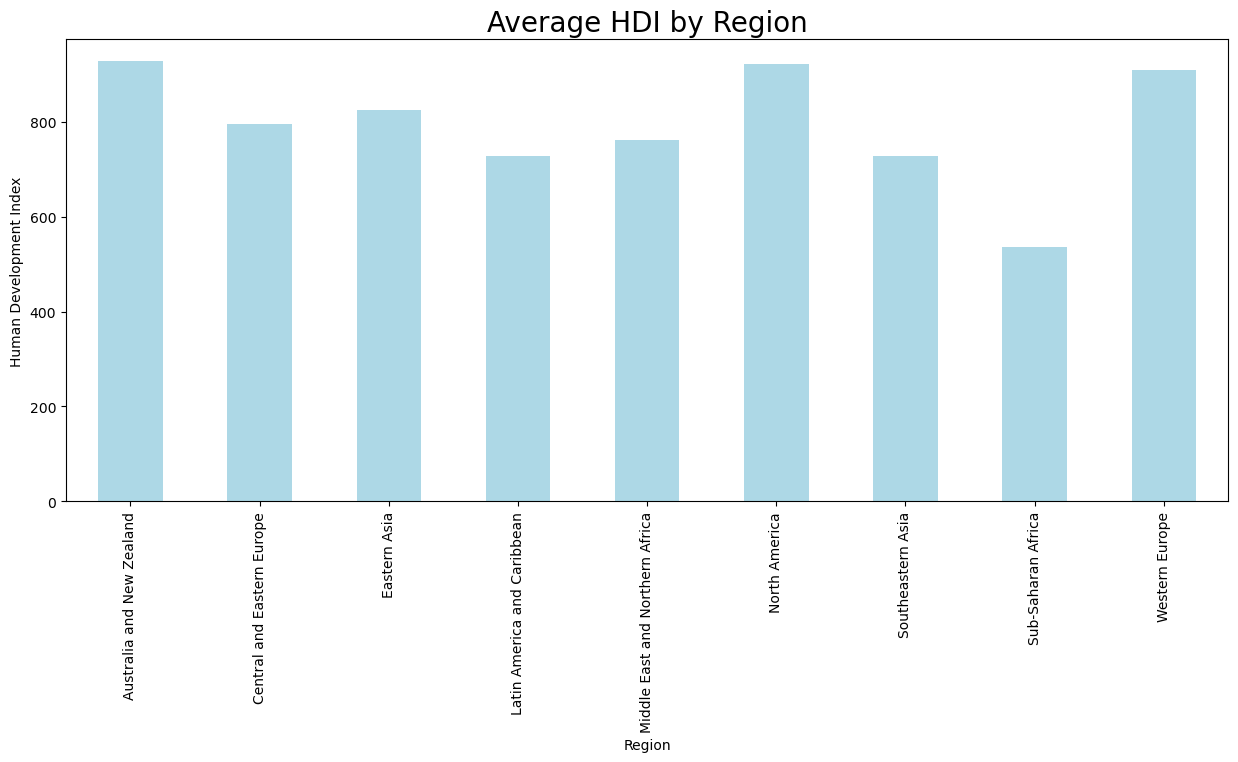

In [34]:
#average HDI per region
plt.figure(figsize=(15, 6))
hdi_df.groupby('Region')['HDI'].mean().plot(kind='bar', color='lightblue')
plt.title('Average HDI by Region', fontsize=20)
plt.xlabel('Region')
plt.ylabel('Human Development Index')
plt.xticks(rotation=90)
plt.show()

Text(0, 0.5, 'Human Development Index')

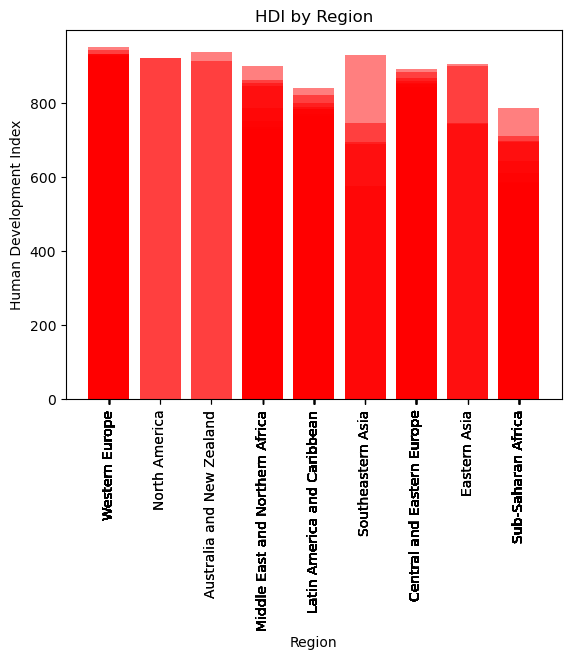

In [35]:
#HDI per region
hdi=hdi_df["HDI"]
region=gdp_df["Region"]

plt.bar(region,hdi,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=90)

plt.title("HDI by Region")
plt.xlabel("Region")
plt.ylabel("Human Development Index")

In [36]:
#Top 25 HDI Countries
hdi=hdi_df.sort_values(["HDI"],ascending=False)
hdi.head(25)

,Country,Region,HDI
3,Norway,Western Europe,951
1,Switzerland,Western Europe,943
8,Australia,Australia and New Zealand,938
14,Germany,Western Europe,934
17,Ireland,Western Europe,934
2,Iceland,Western Europe,933
9,Sweden,Western Europe,932
20,Singapore,Southeastern Asia,930
0,Denmark,Western Europe,928
6,Netherlands,Western Europe,928


<Figure size 1500x1000 with 0 Axes>

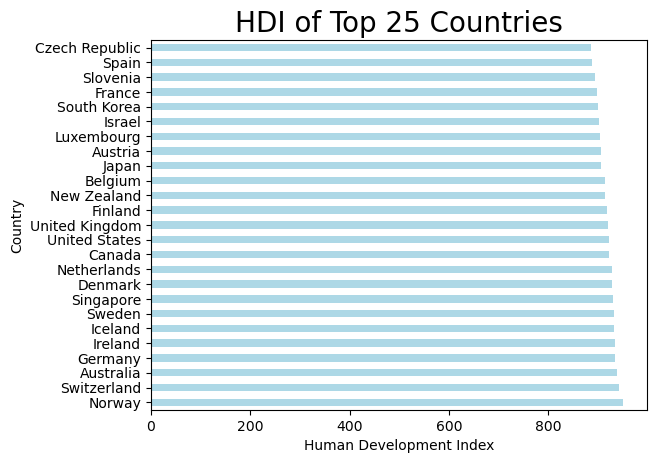

In [37]:
#Top 25 HDI Countries Graph
hdi=hdi_df["HDI"]
country=hdi_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = hdi_df.nlargest(25, 'HDI')
top_25_countries.plot(kind='barh', x='Country', y='HDI', color='lightblue', legend=False)
plt.title('HDI of Top 25 Countries', fontsize=20)
plt.xlabel('Human Development Index')
plt.ylabel('Country')
plt.show()


In [38]:
#bottom 25 HDI Countries
hdi=hdi_df.sort_values(["HDI"],ascending=True)
hdi.head(25)

,Country,Region,HDI
113,Niger,Sub-Saharan Africa,351
114,Chad,Sub-Saharan Africa,405
89,Sierra Leone,Sub-Saharan Africa,413
115,Burkina Faso,Sub-Saharan Africa,420
106,Mali,Sub-Saharan Africa,421
118,Liberia,Sub-Saharan Africa,432
98,Dem. Rep. Congo,Sub-Saharan Africa,452
104,Malawi,Sub-Saharan Africa,474
110,Cote d'Ivoire,Sub-Saharan Africa,486
107,Haiti,Latin America and Caribbean,496


<Figure size 1500x1000 with 0 Axes>

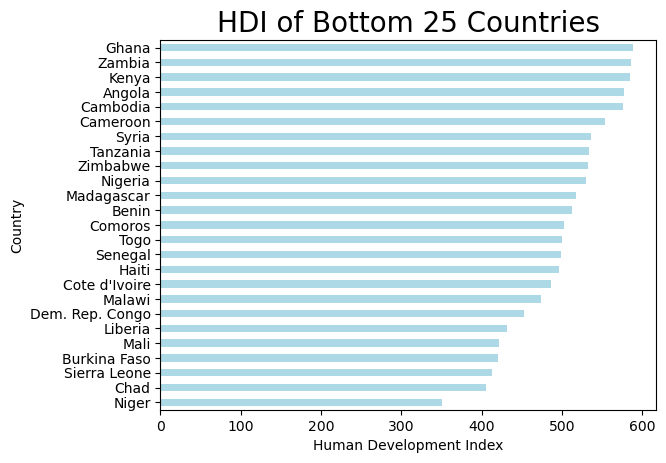

In [39]:
#bottom 25 HDI Countries
hdi=hdi_df["HDI"]
country=hdi_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = hdi_df.nsmallest(25, 'HDI')
top_25_countries.plot(kind='barh', x='Country', y='HDI', color='lightblue', legend=False)
plt.title('HDI of Bottom 25 Countries', fontsize=20)
plt.xlabel('Human Development Index')
plt.ylabel('Country')
plt.show()


## Next Section

In [40]:
#Happy Places
#Happiest places (Top 10)
most_happiest_df = data_df.head(10)
most_happiest_df = most_happiest_df [["Country","HappinessScore"]]
most_happiest_df

,Country,HappinessScore
0,Denmark,7.526
1,Switzerland,7.509
2,Iceland,7.501
3,Norway,7.498
4,Finland,7.413
5,Canada,7.404
6,Netherlands,7.339
7,New Zealand,7.334
8,Australia,7.313
9,Sweden,7.291


In [41]:
least_happiest_df = data_df.tail(10)
least_happiest_df= least_happiest_df [["Country","HappinessScore"]]
least_happiest_df

,Country,HappinessScore
112,Angola,3.866
113,Niger,3.856
114,Chad,3.763
115,Burkina Faso,3.739
116,Madagascar,3.695
117,Tanzania,3.666
118,Liberia,3.622
119,Benin,3.484
120,Togo,3.303
121,Syria,3.069


In [42]:
#Happies Regions (Top 10)HappinessScore
happy_region_df = data_df.groupby(["Region"])["HappinessScore"].mean()
happy_region_df 

Region
Australia and New Zealand          7.323500
Central and Eastern Europe         5.383444
Eastern Asia                       5.477000
Latin America and Caribbean        6.061000
Middle East and Northern Africa    5.443727
North America                      7.254000
Southeastern Asia                  5.492000
Sub-Saharan Africa                 4.151464
Western Europe                     6.731400
Name: HappinessScore, dtype: float64

In [43]:
#Happies Hemisphere
happy_hemisphere_df = data_df.groupby(["Hemisphere"])["HappinessScore"].mean()
happy_hemisphere_df 

Hemisphere
both     5.901600
north    5.626438
south    4.970619
Name: HappinessScore, dtype: float64

Text(0, 0.5, 'Happiness Score')

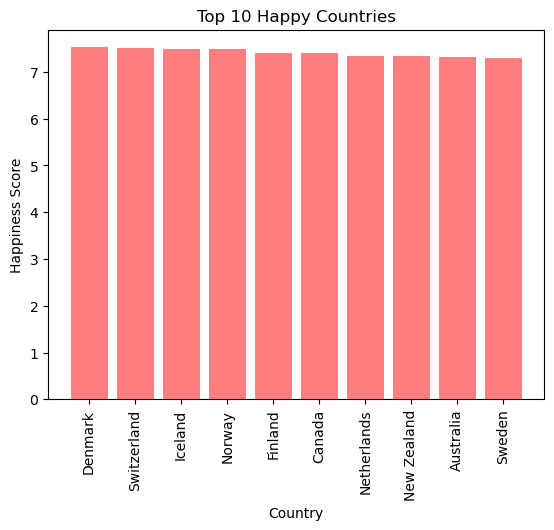

In [44]:
#Happiness Level Visualization
#Most top 10 happy country
happy=most_happiest_df["HappinessScore"]
country=most_happiest_df["Country"]

plt.bar(country,happy,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in country]
plt.xticks(tick_loactions,country,rotation=90)

plt.title("Top 10 Happy Countries")
plt.xlabel("Country")
plt.ylabel("Happiness Score")

Text(0, 0.5, 'Happiness Score')

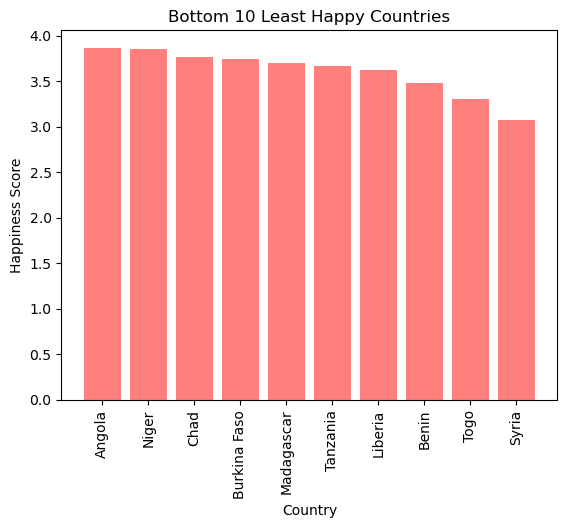

In [45]:
#Happiness Level Visualization
#Bottow 10 least happy country
happy=least_happiest_df["HappinessScore"]
country=least_happiest_df["Country"]

plt.bar(country,happy,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in country]
plt.xticks(tick_loactions,country,rotation=90)

plt.title("Bottom 10 Least Happy Countries")
plt.xlabel("Country")
plt.ylabel("Happiness Score")

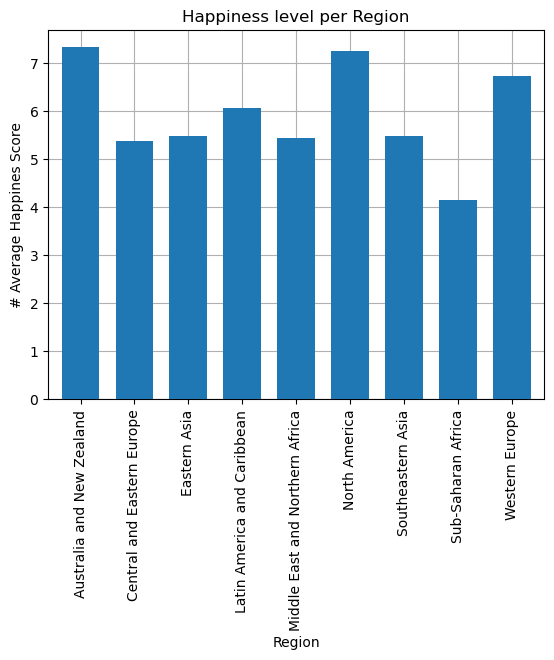

In [46]:
#Happiness level per Region

bar_plot = happy_region_df.plot.bar(width=0.7, zorder=3)

# Set labels for axes
bar_plot.set_xlabel("Region")
bar_plot.set_ylabel("# Average Happines Score")
bar_plot.set_title("Happiness level per Region")


# Create a grid - using 'zorder' places grid behind the bars since we set their z-order higher
bar_plot.grid(zorder=0)

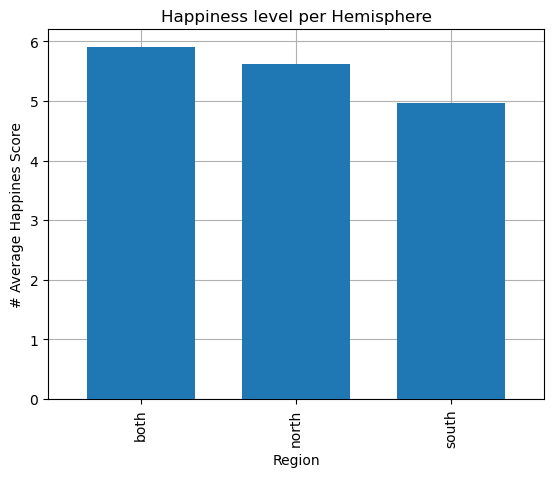

In [47]:
#Happiness level per Hemisphere\n",
bar_plot = happy_hemisphere_df.plot.bar(width=0.7, zorder=3)
# Set labels for axes\n",
bar_plot.set_xlabel("Region")
bar_plot.set_ylabel("# Average Happines Score")
bar_plot.set_title("Happiness level per Hemisphere")
# Create a grid - using 'zorder' places grid behind the bars since we set their z-order higher\n"
bar_plot.grid(zorder=0)

## Alcohol Consumption and Happiness

In [48]:
OH_happiness = merged_data_complete[["Country", "HappinessScore", "Beer_PerCapita", "Spirit_PerCapita", "Wine_PerCapita"]].copy()
len(OH_happiness)

122

In [49]:
# function to create create scatter and linear regression plots
def lin_regress(x_vals, y_vals, color, x_ann, y_ann):
    (slope, intercept, rval, pval, stderr) = linregress(x_vals, y_vals)
    #plt.subplots(figsize=(15, 6))
    print(f"The {x_vals.name} r-value is: {rval}")
    regress_vals = x_vals * slope + intercept
    line_eq = f"y = {round(slope,5)} x + {round(intercept,2)}"
    #title = f"Happiness by {x_label}"
    plt.scatter(x_vals, y_vals, c=color)
    plt.plot(x_vals,regress_vals,color)
    plt.annotate(line_eq,(x_ann, y_ann),fontsize=15,color=color)
    plt.title(f"Happiness by Beverage Consumption")
    #plt.xlabel(f"{x_label}")
    plt.xlabel(f"Beverage Consumption per Capita")
    plt.ylabel(f"Happiness")
    plt.ylim(0, y_vals.max()+1)
    #plt.legend()
    plt.savefig(f"output_data/Happiness by Beverage Consumption.png")



The Beer_PerCapita r-value is: 0.4933672047789534
The Wine_PerCapita r-value is: 0.45058863862674225
The Spirit_PerCapita r-value is: 0.25639894608701114


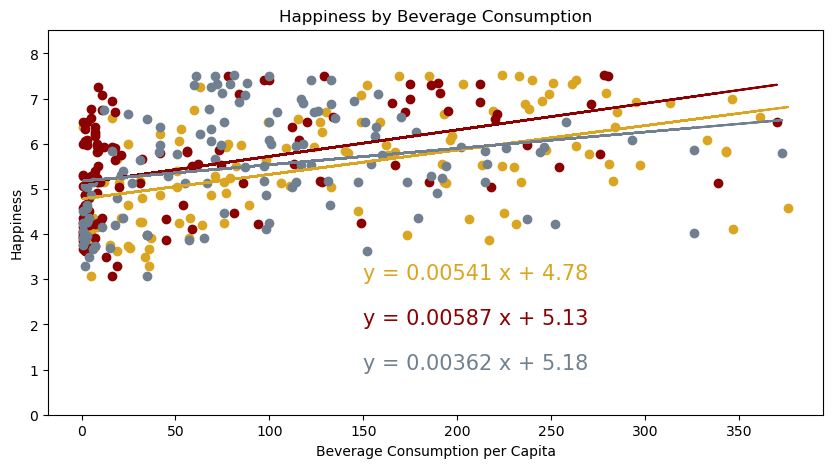

In [50]:

plt.figure(figsize=(10, 5))
beer_scat = lin_regress(OH_happiness["Beer_PerCapita"], OH_happiness["HappinessScore"], "goldenrod", 150, 3)
wine_scat = lin_regress(OH_happiness["Wine_PerCapita"], OH_happiness["HappinessScore"], "darkred", 150, 2)
spirit_scat = lin_regress(OH_happiness["Spirit_PerCapita"], OH_happiness["HappinessScore"], "slategray", 150, 1)

plt.show()

The None r-value is: 0.5474609600344386


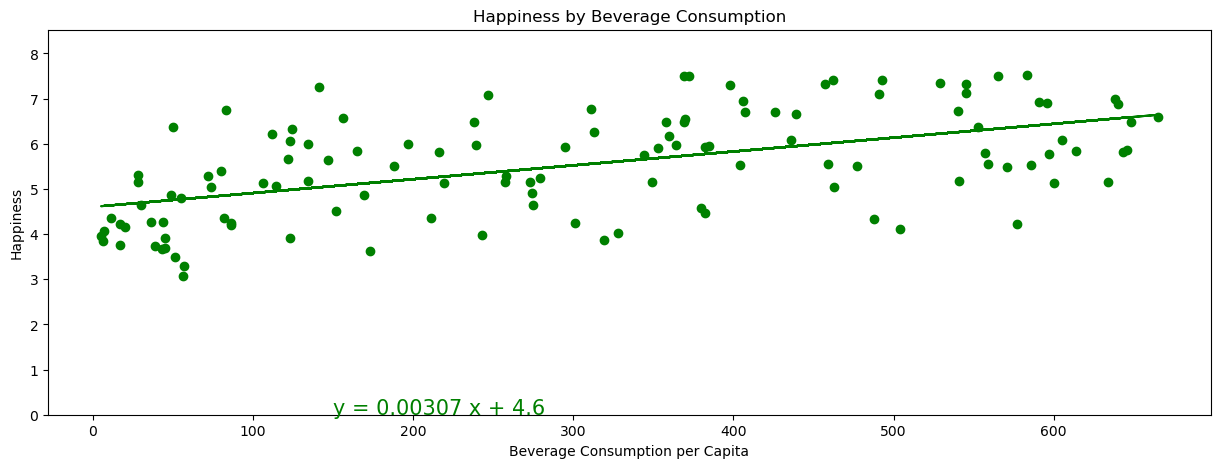

In [51]:
plt.figure(figsize=(15, 5))

all_bevs_scat = lin_regress(
    (OH_happiness["Beer_PerCapita"]+OH_happiness["Wine_PerCapita"]+OH_happiness["Spirit_PerCapita"]),
    OH_happiness["HappinessScore"], "green", 150, 0)